In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit

#Les simulations sauvegardent les données dans des fichiers data_X_ITER.npz

#global variable
w = np.asarray([4./9., 1./9., 1./9., 1./9., 1./9., 1./36., 1./36., 1./36., 1./36.])
cx = np.asarray([0, 1, 0, -1, 0, 1, -1, -1, 1])
cy = np.asarray([0, 0, 1, 0, -1, 1, 1, -1, -1])

cxf = np.asarray([0., 1., 0., -1., 0., 1., -1., -1., 1.])
cyf = np.asarray([0., 0., 1., 0., -1., 1., 1., -1., -1.])

@njit
def compute_eq(rho, ux, uy):
    feq = np.zeros(9)
    for alpha in range(9):
        u_dot_e = cx[alpha]*ux+cy[alpha]*uy
        feq[alpha] = rho*w[alpha]*(1+3*(u_dot_e)+4.5*(u_dot_e*u_dot_e)-1.5*(ux*ux+uy*uy)) #2nd order
        feq[alpha] += rho*w[alpha]*4.5*u_dot_e*(u_dot_e*u_dot_e-(ux*ux+uy*uy)) #3rd order
        feq[alpha] += rho*w[alpha]*(4.5*4.5*ux*ux*uy*uy*(cx[alpha]*cx[alpha]-1./3.)*(cy[alpha]*cy[alpha]-1./3.)) # 4th order
    return feq

@njit
def compute_eq_scal(alpha, rho, ux, uy):
    u_dot_e = cx[alpha]*ux+cy[alpha]*uy
    feq = rho*w[alpha]*(1+3*(u_dot_e)+4.5*(u_dot_e*u_dot_e)-1.5*(ux*ux+uy*uy)) #2nd order
    feq += rho*w[alpha]*4.5*u_dot_e*(u_dot_e*u_dot_e-(ux*ux+uy*uy)) #3rd order
    feq += rho*w[alpha]*(4.5*4.5*ux*ux*uy*uy*(cx[alpha]*cx[alpha]-1./3.)*(cy[alpha]*cy[alpha]-1./3.)) # 4th order
    return feq

@njit
def compute_coll_STD(fcoll, f, tau, NX, NY):
    for i in range(NX):
        for j in range(NY):
            f9 = np.copy(f[:, i, j])
            r = np.sum(f9)
            fcoll[:, i, j] = (1-1./tau)*f9+1./tau*compute_eq(r, f9.dot(cxf)/r, f9.dot(cyf)/r)

@njit
def stream(f, fcoll, NX, NY):
    for alpha in range(9):
        for i in range(NX):
            for j in range(NY):
                f[alpha, i, j] = fcoll[alpha, (i-cx[alpha])%NX, (j-cy[alpha])%NY]

@njit
def Taylor2_LBM(f, f_old, tau, NX, NY):
    f_out = np.zeros((9, NX, NY))
    f_star = np.zeros((9, NX, NY))
    for alpha in range(9):
        for i in range(NX):
            for j in range(NY):
                f1 = np.copy(f[:, (i-cx[alpha])%NX, (j-cy[alpha])%NY])
                r1 = np.sum(f1)
                ux1 = f1.dot(cxf)/r1
                uy1 = f1.dot(cyf)/r1
                f2 = np.copy(f_old[:, (i-2*cx[alpha])%NX, (j-2*cy[alpha])%NY])
                r2 = np.sum(f2)
                ux2 = f2.dot(cxf)/r2
                uy2 = f2.dot(cyf)/r2
                f_star[alpha, i, j] = (tau*tau-tau)*compute_eq_scal(alpha, r2, ux2, uy2)\
                +(-2*tau*tau+3*tau)*compute_eq_scal(alpha, r1, ux1, uy1)
    for i in range(NX):
        for j in range(NY):
            f9 = np.copy(f_star[:, i, j])
            r9 = np.sum(f9)/(2*tau-tau*tau)
            ux9 = f9.dot(cxf)/(2*tau-tau*tau)/r9
            uy9 = f9.dot(cyf)/(2*tau-tau*tau)/r9
            f_out[:, i, j] = f9+(tau-1)*(tau-1)*compute_eq(r9, ux9, uy9)
    return f_out


@njit
def Taylor2_LBM_opt(r, u, v, r_old, u_old, v_old, tau, NX, NY):
    r_out = np.zeros((NX, NY))
    u_out = np.zeros((NX, NY))
    v_out = np.zeros((NX, NY))
    f_star = np.zeros(9)
    for i in range(NX):
        for j in range(NY):
            for alpha in range(9):
                i1 = (i-cx[alpha])%NX
                j1 = (j-cy[alpha])%NY
                i2 = (i-2*cx[alpha])%NX
                j2 = (j-2*cy[alpha])%NY
                f_star[alpha] = (tau*tau-tau)*compute_eq_scal(alpha, r_old[i2, j2], u_old[i2, j2], v_old[i2, j2])\
                +(-2*tau*tau+3*tau)*compute_eq_scal(alpha, r[i1, j1], u[i1, j1], v[i1, j1])
            r_out[i, j] = np.sum(f_star)/(2*tau-tau*tau)
            u_out[i, j] = f_star.dot(cxf)/(2*tau-tau*tau)/r_out[i, j]
            v_out[i, j] = f_star.dot(cyf)/(2*tau-tau*tau)/r_out[i, j]
    return r_out, u_out, v_out, r, u, v



In [5]:
# paramètre de la simulation 

NX = 256
NY = NX
k = 2*np.pi/float(NX)
#t_range = np.arange(1000, 1003+1, 1)
t_range = np.asarray([0, 500, 1000, 1500, 1998, 1999, 2000])
M = 0.3
U0 = M/np.sqrt(3)
Re = 30000.
nu = U0*NX/Re
tau = 3*nu
taug = 3*nu+0.5

#taug=0.51

print('taug= '+str(taug))
print('U0= '+str(U0))

taug= 0.5044340500673763
U0= 0.17320508075688773


In [6]:
#Simulation avec LBM-BGK

f = np.zeros((9, NX, NY))
fcoll = np.zeros((9, NX, NY))
fold = np.zeros((9, NX, NY))

rho = np.zeros((NX, NY))
ux = np.zeros((NX, NY))
uy = np.zeros((NX, NY))

rho_old = np.zeros((NX, NY))
ux_old = np.zeros((NX, NY))
uy_old = np.zeros((NX, NY))

#init 
for i in range(NX):
        for j in range(NY):
                #Double shear layer
                if j <= NX/2:
                    ux[i, j] = U0*np.tanh(80*(j/NX-0.25))
                else:
                    ux[i, j] = U0*np.tanh(80*(0.75-j/NX))
                uy[i, j] = 0.05*U0*np.sin(2*np.pi*(i/float(NX)+0.25))
                rho[i, j] = 1.
                f[:, i, j] = compute_eq(rho[i,j], ux[i,j], uy[i,j])


rho = np.sum(f, axis=0)
ux = np.sum([cxf[alpha]*f[alpha, :, :] for alpha in range(9)], axis=0)/rho
uy = np.sum([cyf[alpha]*f[alpha, :, :] for alpha in range(9)], axis=0)/rho
np.savez('data_0', rho=rho, ux=ux, uy=uy)

#program start 

# -----LBM-BGK-----
print("LBM-BGK starts...")
start = time.time()
for t in range(t_range[-1]+1):
    compute_coll_STD(fcoll, f, taug, NX, NY)
    stream(f, fcoll, NX, NY)

    if np.any(t_range[1:] == t):
        finish = time.time()
        rho = np.sum(f, axis=0)
        ux = np.sum([cxf[alpha]*f[alpha, :, :] for alpha in range(9)], axis=0)/rho
        uy = np.sum([cyf[alpha]*f[alpha, :, :] for alpha in range(9)], axis=0)/rho
        np.savez('data_LBM_'+str(t), rho=rho, ux=ux, uy=uy, f=f)
        print("iteration: "+str(t)+" ... total  mass "+str(np.sum(rho))+" in "+str(finish-start)+" s")
print("execution speed  =  "+str(NX*NY*t/(finish-start)/10**6)+" MLUPS in "+str(finish-start)+" s")



LBM-BGK starts...
iteration: 500 ... total  mass 65535.999999996384 in 13.531306505203247 s
iteration: 1000 ... total  mass 65535.99999999278 in 27.34571361541748 s
iteration: 1500 ... total  mass 65535.99999998921 in 43.46982169151306 s
iteration: 1998 ... total  mass 65535.99999998565 in 59.54273509979248 s
iteration: 1999 ... total  mass 65535.99999998565 in 59.58745718002319 s
iteration: 2000 ... total  mass 65535.999999985645 in 59.63101005554199 s
execution speed  =  2.1980509784743854 MLUPS in 59.63101005554199 s


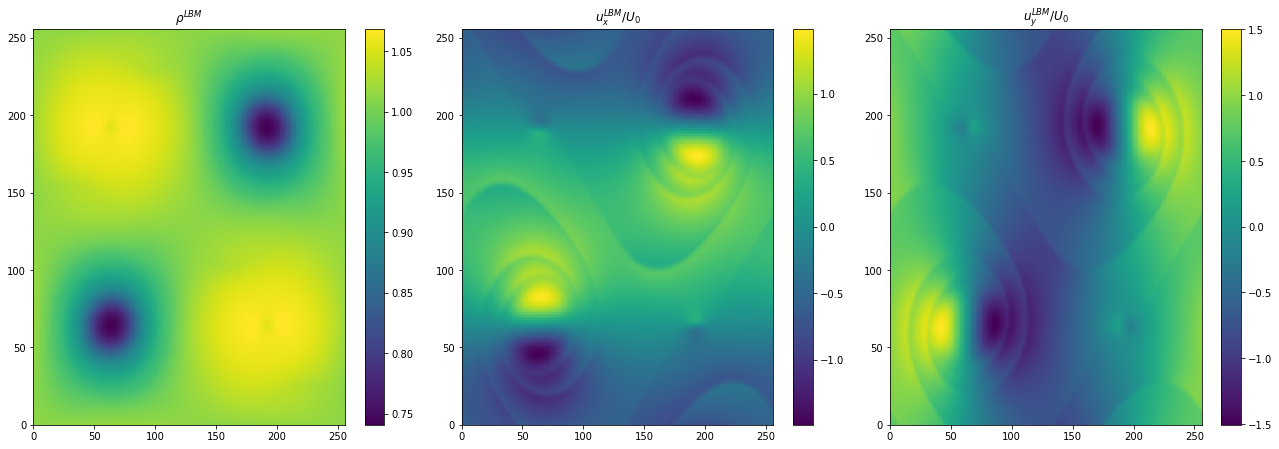

In [8]:
#Comparaison LBM-BGK / LBM-Taylor

t = 2000
data_LBM = np.load('data_LBM_'+str(t)+'.npz')


#fig = plt.figure(figsize=(18,6))
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)


cs1 = ax1.pcolormesh(data_LBM['rho'].T)
cs2 = ax2.pcolormesh(data_LBM['ux'].T/U0)
cs3 = ax3.pcolormesh(data_LBM['uy'].T/U0)


fig.colorbar(cs1, ax=ax1)
fig.colorbar(cs2, ax=ax2)
fig.colorbar(cs3, ax=ax3)
ax1.set_title(r'$\rho^{LBM}$')
ax2.set_title(r'$u_x^{LBM}/U_0$')
ax3.set_title(r'$u_y^{LBM}/U_0$')

plt.tight_layout()



plt.show()
